In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

2025-05-29 16:14:58.319086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748535298.511793      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748535298.564440      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


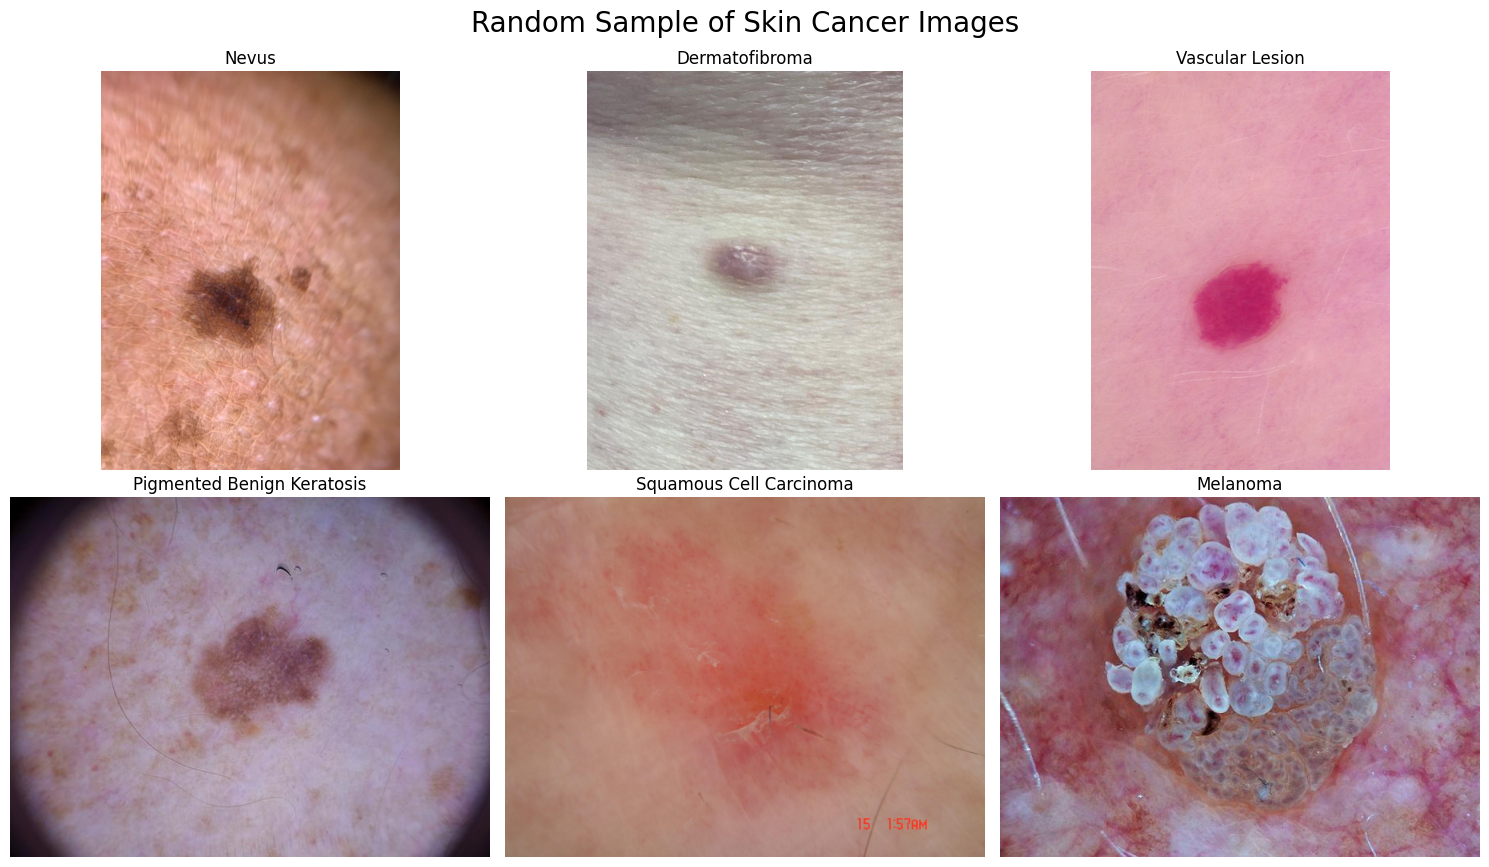

In [4]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Base directory
base_dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer Dataset"

# Dictionary to hold image paths and labels
image_paths = []

# Load all images from all subfolders
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append((img_path, class_name))

# Shuffle and take 6 random samples
sample_images = random.sample(image_paths, 6)

# Display the images
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
    img_path, label = sample_images[i]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i // 3, i % 3].imshow(image)
    ax[i // 3, i % 3].axis('off')
    ax[i // 3, i % 3].set_title(label)

fig.suptitle('Random Sample of Skin Cancer Images', fontsize=20)
plt.tight_layout()
plt.show()


In [5]:
import os
import cv2
import numpy as np
from PIL import Image

data = []
labels = []

base_path = "/kaggle/input/skin-cancer-dataset/Skin Cancer Dataset"

# Automatically get class names
class_folders = sorted(os.listdir(base_path))  # ['Melanoma', 'Nevus', ...]

for label, class_name in enumerate(class_folders):
    class_path = os.path.join(base_path, class_name)

    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name} (Label: {label})")

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Skipping unreadable image: {img_name}")
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(image_rgb)
            resized_image = image_pil.resize((224, 224))

            data.append(np.array(resized_image))
            labels.append(label)
        except Exception as e:
            print(f"Error processing image {img_name} in {class_name}: {e}")


Processing class: Acitinic Keratosis (Label: 0)
Processing class: Basal Cell Carcinoma (Label: 1)
Processing class: Dermatofibroma (Label: 2)
Skipping unreadable image: metadata.csv
Processing class: Melanoma (Label: 3)
Processing class: Nevus (Label: 4)
Processing class: Pigmented Benign Keratosis (Label: 5)
Processing class: Seborrheic Keratosis (Label: 6)
Processing class: Squamous Cell Carcinoma (Label: 7)
Processing class: Vascular Lesion (Label: 8)


In [4]:
import os
import cv2
import numpy as np
from PIL import Image

data = []
labels = []

# Base directory where the class folders (e.g., Melanoma, Nevus, etc.) are located
base_path = "/kaggle/input/dataset-skin-cancer/Skin Cancer Dataset"
class_folders = sorted(os.listdir(base_path))  # List all class folders (9 classes)

for label, class_name in enumerate(class_folders):
    class_path = os.path.join(base_path, class_name)  # Removed "train"

    if not os.path.isdir(class_path):
        continue  # Skip files or corrupted entries

    print(f"Resizing images in class: {class_name} (Label: {label})")

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            image = cv2.imread(img_path)
            if image is None:
                continue  # Skip unreadable files

            # Convert BGR to RGB and resize to 224x224
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(image_rgb)
            resized_image = image_pil.resize((224, 224))

            data.append(np.array(resized_image))
            labels.append(label)

        except Exception as e:
            print(f"Error with image {img_name} in {class_name}: {e}")


Resizing images in class: Acitinic Keratosis (Label: 0)
Resizing images in class: Basal Cell Carcinoma (Label: 1)
Resizing images in class: Dermatofibroma (Label: 2)
Resizing images in class: Melanoma (Label: 3)
Resizing images in class: Nevus (Label: 4)
Resizing images in class: Pigmented Benign Keratosis (Label: 5)
Resizing images in class: Seborrheic Keratosis (Label: 6)
Resizing images in class: Squamous Cell Carcinoma (Label: 7)
Resizing images in class: Vascular Lesion (Label: 8)


In [6]:
import numpy as np
from tensorflow.keras.utils import to_categorical

feats = np.array(data, dtype='float32')  # shape: (num_samples, 224, 224, 3)
labels = np.array(labels)                # shape: (num_samples,)

# Normalize to [0, 1]
feats = feats / 255.0

# One-hot encode labels for 9 classes
labels = to_categorical(labels, num_classes=9)


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    feats, labels, test_size=0.2, stratify=labels, random_state=42
)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

valAug = ImageDataGenerator()  # No augmentation for validation


In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense

input_tensor = Input(shape=(224, 224, 3))  # Keras tensor
baseModel = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=input_tensor)

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
output_tensor = Dense(9, activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output_tensor)


I0000 00:00:1748535639.035013      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint("efficientnetb0_best.h5", save_best_only=True)
]


In [13]:
BS = 32
H1 = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
    validation_data=valAug.flow(x_test, y_test, batch_size=BS),
   
    epochs=40,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1748535812.070508     102 service.cc:148] XLA service 0x7afb3c0045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748535812.071256     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748535817.515035     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748535827.100578     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535827.287983     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535827.763547     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535827.9700

109/116 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.3626 - loss: 1.7659

E0000 00:00:1748535897.683367      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535897.868725      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535898.319779      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535898.528530      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748535898.888131      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

116/116 ━━━━━━━━━━━━━━━━━━━━ 184s 753ms/step - accuracy: 0.3696 - loss: 1.7479 - val_accuracy: 0.1069 - val_loss: 3.3113 - learning_rate: 0.0010
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 335ms/step - accuracy: 0.6073 - loss: 1.1201 - val_accuracy: 0.1069 - val_loss: 2.8814 - learning_rate: 0.0010
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 328ms/step - accuracy: 0.6589 - loss: 0.9325 - val_accuracy: 0.1166 - val_loss: 3.1428 - learning_rate: 0.0010
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7315 - loss: 0.7800
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 329ms/step - accuracy: 0.7314 - loss: 0.7803 - val_accuracy: 0.0810 - val_loss: 3.4807 - learning_rate: 0.0010
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.7774 - loss: 0.6395 - val_accuracy: 0.1080 - val_loss: 3.8924 - learning_rate: 5.0000e-04
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8500 - los

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.9846 - loss: 0.0615 - val_accuracy: 0.8002 - val_loss: 0.7509 - learning_rate: 1.0000e-07
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9688 - loss: 0.0842 - val_accuracy: 0.7991 - val_loss: 0.7508 - learning_rate: 1.0000e-07
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.9837 - loss: 0.0651 - val_accuracy: 0.7946 - val_loss: 0.7570 - learning_rate: 1.0000e-07
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0548 - val_accuracy: 0.7991 - val_loss: 0.7380 - learning_rate: 1.0000e-07
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step - accuracy: 0.9802 - loss: 0.0613 - val_accuracy: 0.8002 - val_loss: 0.7357 - learning_rate: 1.0000e-07
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.0948 - val_accuracy: 0.7980 - val_loss: 0.7494 - learning_rate: 1.0000e-07
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step -

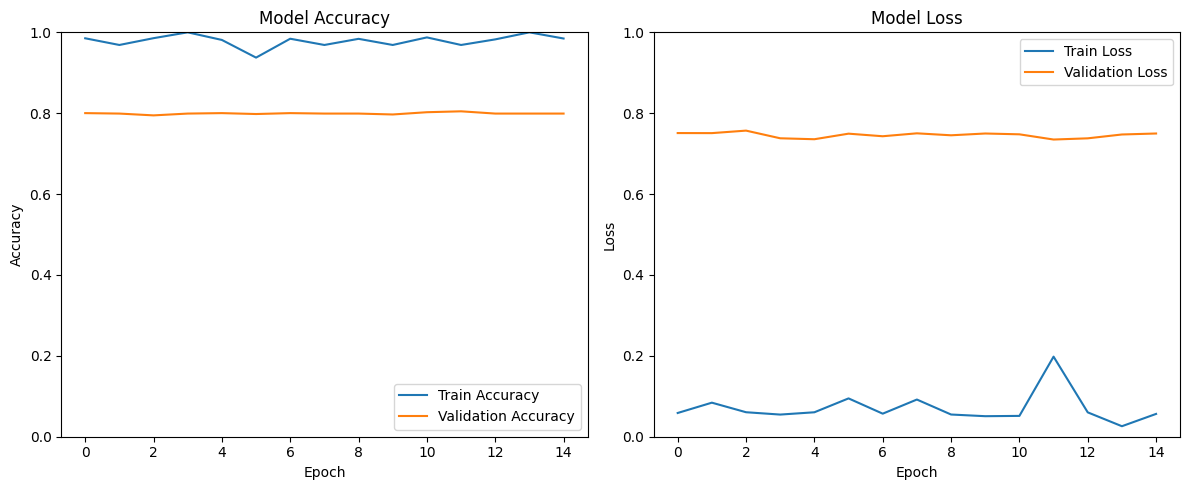

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step


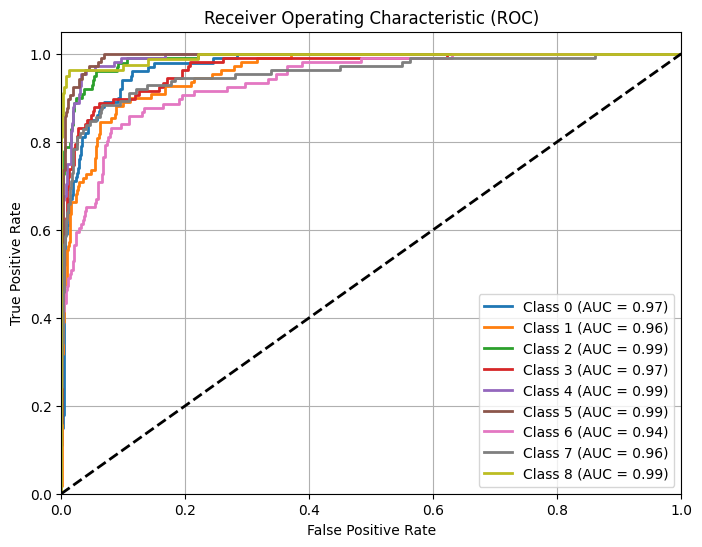

In [16]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ===== 1. Set baseModel trainability =====
baseModel.trainable = True
for layer in baseModel.layers[:-30]:  # Unfreeze last 20 layers
    layer.trainable = False

# ===== 2. Compile the model =====
model.compile(
    optimizer=Adam(learning_rate=1e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===== 3. Train the model =====
H2 = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
    validation_data=valAug.flow(x_test, y_test, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    validation_steps=len(x_test) // BS,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

# ===== 4. Plot Training/Validation Accuracy and Loss =====
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(H2.history['accuracy'], label='Train Accuracy')
plt.plot(H2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1) 
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(H2.history['loss'], label='Train Loss')
plt.plot(H2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1) 
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ===== 5. Plot ROC Curves (Multi-Class) =====
# Predict probabilities
y_score = model.predict(x_test)

# Ensure y_test is in one-hot encoding
if y_test.ndim == 1 or y_test.shape[1] == 1:
    from tensorflow.keras.utils import to_categorical
    y_test_bin = to_categorical(y_test, num_classes=y_score.shape[1])
else:
    y_test_bin = y_test

n_classes = y_score.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


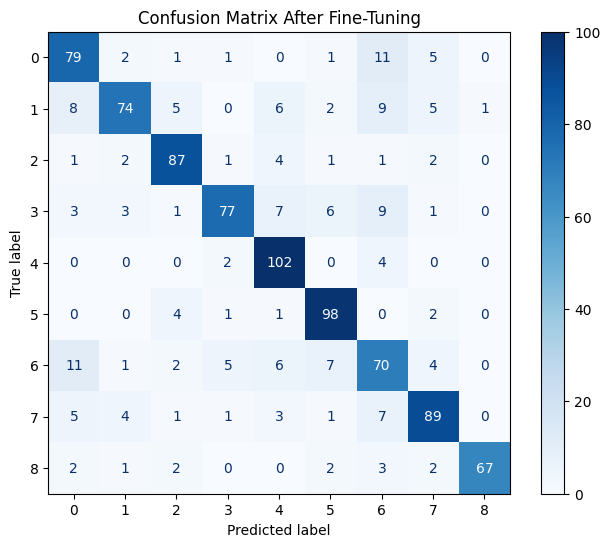

Classification Report:

              precision    recall  f1-score   support

           0     0.7248    0.7900    0.7560       100
           1     0.8506    0.6727    0.7513       110
           2     0.8447    0.8788    0.8614        99
           3     0.8750    0.7196    0.7897       107
           4     0.7907    0.9444    0.8608       108
           5     0.8305    0.9245    0.8750       106
           6     0.6140    0.6604    0.6364       106
           7     0.8091    0.8018    0.8054       111
           8     0.9853    0.8481    0.9116        79

    accuracy                         0.8024       926
   macro avg     0.8138    0.8045    0.8053       926
weighted avg     0.8093    0.8024    0.8019       926



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Step 1: Predict on test data
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Display confusion matrix with fixed color scale
labels = [str(i) for i in range(cm.shape[0])]  # Or use custom class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)

# Set the color scale (vmin, vmax) manually using the axis object
# Use imshow's property for color limits (vmin, vmax)
ax.images[0].set_clim(0, 100)  # Set color limits

plt.title("Confusion Matrix After Fine-Tuning")
plt.show()

# Step 4: Print precision, recall, f1-score, and support
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict before fine-tuning (immediately after Phase 1)
y_pred_probs_phase1 = model.predict(x_test)
y_pred_phase1 = np.argmax(y_pred_probs_phase1, axis=1)
y_true = np.argmax(y_test, axis=1)  # assuming one-hot encoded labels

# Compute confusion matrix
cm_phase1 = confusion_matrix(y_true, y_pred_phase1)

# Display confusion matrix
labels = [str(i) for i in range(cm_phase1.shape[0])]  # or use class_names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm_phase1, display_labels=labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix Before Fine-Tuning (Phase 1)")
plt.show()
